# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

import matplotlib.pyplot as plt

**Открываем файлы с данными геологоразведки трёх регионов**

In [2]:
data_1 = pd.read_csv('/datasets/geo_data_0.csv')
data_2 = pd.read_csv('/datasets/geo_data_1.csv')
data_3 = pd.read_csv('/datasets/geo_data_2.csv')

**Описание данных**

- **id** — уникальный идентификатор скважины;
- **f0, f1, f2** — три признака точек (неважно, что они означают, но сами признаки значимы);
- **product** — объём запасов в скважине (тыс. баррелей).

**Перед началом обучения модели следует избавится от цисловых ID, эти данные не нужны для дальнейшей работы**

In [3]:
drops=['id']
data_1=data_1.drop(drops,axis=1)
data_2=data_2.drop(drops,axis=1)
data_3=data_3.drop(drops,axis=1)

### Данные 1 региона

In [4]:
data_1.head()

,f0,f1,f2,product
0,0.705745,-0.497823,1.221170,105.280062
1,1.334711,-0.340164,4.365080,73.037750
2,1.022732,0.151990,1.419926,85.265647
3,-0.032172,0.139033,2.978566,168.620776
4,1.988431,0.155413,4.751769,154.036647


In [5]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.1 MB


Пропусков данных нет, проверим на явные дубликаты

In [6]:
data_1.duplicated().sum()

0

### Данные 2 региона

In [7]:
data_2.head()

,f0,f1,f2,product
0,-15.001348,-8.276000,-0.005876,3.179103
1,14.272088,-3.475083,0.999183,26.953261
2,6.263187,-5.948386,5.001160,134.766305
3,-13.081196,-11.506057,4.999415,137.945408
4,12.702195,-8.147433,5.004363,134.766305


In [8]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.1 MB


Пропусков данных нет, проверим на явные дубликаты

In [9]:
data_2.duplicated().sum()

0

### Данные 3 региона

In [10]:
data_3.head()

,f0,f1,f2,product
0,-1.146987,0.963328,-0.828965,27.758673
1,0.262778,0.269839,-2.530187,56.069697
2,0.194587,0.289035,-5.586433,62.871910
3,2.236060,-0.553760,0.930038,114.572842
4,-0.515993,1.716266,5.899011,149.600746


In [11]:
data_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.1 MB


In [12]:
data_3.duplicated().sum()

0

### График распределения запасов сырья в регионах

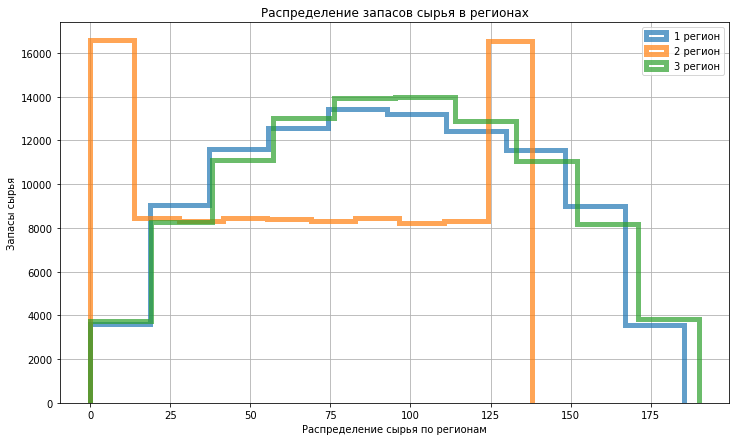

In [13]:
plt.title('Распределение запасов сырья в регионах')
ax=data_1['product'].plot(kind='hist',figsize=(12,7),grid=True, legend=True, alpha=0.7, histtype='step', linewidth=5, label='1 регион')
ax1=data_2['product'].plot(kind='hist',figsize=(12,7),grid=True, legend=True, alpha=0.7,histtype='step', linewidth=5, label='2 регион', ax=ax)
data_3['product'].plot(kind='hist',figsize=(12,7),grid=True, legend=True, alpha=0.7,histtype='step', linewidth=5, label='3 регион', ax=ax1)
plt.xlabel('Распределение сырья по регионам')
plt.ylabel('Запасы сырья')
plt.show()

### Итог

- Информация по трем регионам успесно загружена
- Предобработка данных не нужна
- В данных отсутствуют пропуски и дубликаты
- 1 и 3 региони показывают нормальный график распределиния, по сравнению с 2 регионом

## Обучение и проверка модели

### **Разобьём данные на обучающую и валидационную выборки**

In [15]:
target_1=data_1['product']
features_1=data_1.drop(['product'], axis=1)
features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(features_1, target_1, test_size=0.25, random_state=42)

target_2=data_2['product']
features_2=data_2.drop(['product'], axis=1)
features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(features_2, target_2, test_size=0.25, random_state=42)

target_3=data_3['product']
features_3=data_3.drop(['product'], axis=1)
features_train_3, features_valid_3, target_train_3, target_valid_3 = train_test_split(features_3, target_3, test_size=0.25, random_state=42)

### Обучим модель и сделайте предсказания на валидационной выборке

**Для каждой модели запишите параметры и значения RMSE и R2 на валидационной выборке**

RMSE (квадратный корень из средней квадратичной ошибки) прогнозирует среднее значение целевого признака

Коэффициент детерминации, или метрика R2, вычисляет долю
среднеквадратичной ошибки модели от MSE среднего, а затем вычитает
эту величину из единицы. Увеличение метрики означает прирост
качества модели.

In [16]:
model_1=LinearRegression()
model_1.fit(features_train_1,target_train_1)
predict_1=model_1.predict(features_valid_1)
rmse_1= mean_squared_error(target_valid_1, predict_1)**0.5
print('RMSE 1 региона: %.2f' % rmse_1)
print('R2 1 региона: %.2f' % r2_score(target_valid_1, predict_1))

RMSE 1 региона: 37.76
R2 1 региона: 0.27


In [17]:
model_2=LinearRegression()
model_2.fit(features_train_2,target_train_2)
predict_2=model_2.predict(features_valid_2)
rmse_2 = mean_squared_error(target_valid_2, predict_2)**0.5
print('RMSE 2 региона: %.2f'% rmse_2)
print('R2 2 региона: %.2f' % r2_score(target_valid_2, predict_2))

RMSE 2 региона: 0.89
R2 2 региона: 1.00


In [18]:
model_3=LinearRegression()
model_3.fit(features_train_3,target_train_3)
predict_3=model_3.predict(features_valid_3)
rmse_3 = mean_squared_error(target_valid_3, predict_3)**0.5
print('RMSE 3 региона: %.2f'% rmse_3)
print('R2 3 региона: %.2f' % r2_score(target_valid_3, predict_3))

RMSE 3 региона: 40.15
R2 3 региона: 0.20


### **Сохраняем предсказания и правильные ответы на валидационной выборке**

In [19]:
print('1 регион:\n- предсказания: "predict_1"\n- правильные ответы: "target_valid_1"')
print()
print('2 регион:\n- предсказания: "predict_2"\n- правильные ответы: "target_valid_2"')
print()
print('3 регион:\n- предсказания: "predict_3"\n- правильные ответы: "target_valid_3"')

1 регион:
- предсказания: "predict_1"
- правильные ответы: "target_valid_1"

2 регион:
- предсказания: "predict_2"
- правильные ответы: "target_valid_2"

3 регион:
- предсказания: "predict_3"
- правильные ответы: "target_valid_3"


### **Напечатаем на экране средний запас предсказанного сырья и RMSE модели**

In [20]:
print('1 регион:')
print('Средний запас сырья: %.2f' % predict_1.mean())
print('RMSE: %.2f' % rmse_1)
print()
print('2 регион:')
print('Средний запас сырья: %.2f' % predict_2.mean())
print('RMSE: %.2f' % rmse_2)
print()
print('3 регион:')
print('Средний запас сырья: %.2f' % predict_3.mean())
print('RMSE: %.2f' % rmse_3)

1 регион:
Средний запас сырья: 92.40
RMSE: 37.76

2 регион:
Средний запас сырья: 68.71
RMSE: 0.89

3 регион:
Средний запас сырья: 94.77
RMSE: 40.15


### **Проанализируем результаты**

- Модели успешно обучены, ошибок в коде нет
- Проверили качество моделей через RMSE
- Во 2 регионе RMSE отличается от двух других, это можно видеть на графике распределения, размер его данных был почти идентичным, а показатель R2 = 1, что говорит, доля среднеквадратичных ошибок отсутствует
- Предсказали средний завас сырья по каждому региону

## Подготовка к расчёту прибыли

### Все ключевые значения для расчётов сохраните в отдельных переменных

**Условия:**

- При разведке региона исследуют **500 точек**, из которых с помощью машинного обучения выбирают **200 лучших** для разработки.
- Бюджет на разработку скважин в регионе — **10 млрд рублей**.
- При нынешних ценах один баррель сырья приносит **450 рублей дохода**. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность **убытков меньше 2.5%**. Среди них выбирают регион с наибольшей средней прибылью.

Константы запишем так:
- BUDGET: бюджет на разработку скважин в регионе, тыс.руб
- INCOME_PER_PROD: доход с каждой единицы продукта, тыс.руб
- target_probability_losses: вероятность убытков

In [21]:
BUDGET = 10000000
INCOME_PER_PROD = 450
target_probability_losses = 2.5/100
product_mean_1 = data_1['product'].mean()
product_mean_2 = data_2['product'].mean()
product_mean_3 = data_3['product'].mean()

In [22]:
print('Cредний запас сырья в 1 регионе: %.2f млн.баррелей'%product_mean_1)
print('Cредний запас сырья в 2 регионе: %.2f млн.баррелей'%product_mean_2)
print('Cредний запас сырья в 3 регионе: %.2f млн.баррелей'%product_mean_3)

Cредний запас сырья в 1 регионе: 92.50 млн.баррелей
Cредний запас сырья в 2 регионе: 68.83 млн.баррелей
Cредний запас сырья в 3 регионе: 95.00 млн.баррелей


In [23]:
budget_per_point=(BUDGET/200)
print('Бюджет на разработку одной скважины:', budget_per_point/1000,'млн.руб')

Бюджет на разработку одной скважины: 50.0 млн.руб


### Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. Сравним полученный объём сырья со средним запасом в каждом регионе

**Рассчитаем достаточный объём сырья**

In [24]:
v_prod=budget_per_point/INCOME_PER_PROD
print('Достаточный объём каждой скважины для безубыточной разработки должен составлять не менее: %.2f'%v_prod,'тыс.баррелей')

Достаточный объём каждой скважины для безубыточной разработки должен составлять не менее: 111.11 тыс.баррелей


**Сравним полученный объём сырья со средним запасом в каждом регионе**

Инвесторы хотят знать, когда их вложения окупятся. Для них главная метрика — ROI (от англ. return on investments, «возврат на инвестиции»)

**1 регион**

In [25]:
data_1['profit']=(data_1['product']*(INCOME_PER_PROD)).round(2)
data_1.head()

,f0,f1,f2,product,profit
0,0.705745,-0.497823,1.221170,105.280062,47376.03
1,1.334711,-0.340164,4.365080,73.037750,32866.99
2,1.022732,0.151990,1.419926,85.265647,38369.54
3,-0.032172,0.139033,2.978566,168.620776,75879.35
4,1.988431,0.155413,4.751769,154.036647,69316.49


**Определим ROI**

In [26]:
data_1['roi_%']=((data_1['profit']-budget_per_point)/budget_per_point*100).round(2)
data_1.head()

,f0,f1,f2,product,profit,roi_%
0,0.705745,-0.497823,1.221170,105.280062,47376.03,-5.25
1,1.334711,-0.340164,4.365080,73.037750,32866.99,-34.27
2,1.022732,0.151990,1.419926,85.265647,38369.54,-23.26
3,-0.032172,0.139033,2.978566,168.620776,75879.35,51.76
4,1.988431,0.155413,4.751769,154.036647,69316.49,38.63


In [27]:
print('Разница объёма сырья для безубыточной разработки скважины и среднего значения по 1 региону составляет: {:.2%}'.format(product_mean_1/v_prod-1))
print('Разница составляет {:.2f} тыс.баррелей'.format(v_prod-product_mean_1))

Разница объёма сырья для безубыточной разработки скважины и среднего значения по 1 региону составляет: -16.75%
Разница составляет 18.61 тыс.баррелей


**2 регион**

In [28]:
data_2['profit']=(data_2['product']*(INCOME_PER_PROD)).round(2)
data_2.head()

,f0,f1,f2,product,profit
0,-15.001348,-8.276000,-0.005876,3.179103,1430.60
1,14.272088,-3.475083,0.999183,26.953261,12128.97
2,6.263187,-5.948386,5.001160,134.766305,60644.84
3,-13.081196,-11.506057,4.999415,137.945408,62075.43
4,12.702195,-8.147433,5.004363,134.766305,60644.84


**Определим ROI**

In [29]:
data_2['roi_%']=((data_2['profit']-budget_per_point)/budget_per_point*100).round(2)
data_2.head()

,f0,f1,f2,product,profit,roi_%
0,-15.001348,-8.276000,-0.005876,3.179103,1430.60,-97.14
1,14.272088,-3.475083,0.999183,26.953261,12128.97,-75.74
2,6.263187,-5.948386,5.001160,134.766305,60644.84,21.29
3,-13.081196,-11.506057,4.999415,137.945408,62075.43,24.15
4,12.702195,-8.147433,5.004363,134.766305,60644.84,21.29


In [30]:
print('Разница объёма сырья для безубыточной разработки скважины и среднего значения по 2 региону составляет: {:.2%}'.format(product_mean_2/v_prod-1))
print('Разница составляет {:.2f} тыс.баррелей'.format(v_prod-product_mean_2))

Разница объёма сырья для безубыточной разработки скважины и среднего значения по 2 региону составляет: -38.06%
Разница составляет 42.29 тыс.баррелей


**3 регион**

In [31]:
data_3['profit']=(data_3['product']*(INCOME_PER_PROD)).round(2)
data_3.head()

,f0,f1,f2,product,profit
0,-1.146987,0.963328,-0.828965,27.758673,12491.40
1,0.262778,0.269839,-2.530187,56.069697,25231.36
2,0.194587,0.289035,-5.586433,62.871910,28292.36
3,2.236060,-0.553760,0.930038,114.572842,51557.78
4,-0.515993,1.716266,5.899011,149.600746,67320.34


**Определим ROI**

In [32]:
data_3['roi_%']=((data_3['profit']-budget_per_point)/budget_per_point*100).round(2)
data_3.head()

,f0,f1,f2,product,profit,roi_%
0,-1.146987,0.963328,-0.828965,27.758673,12491.40,-75.02
1,0.262778,0.269839,-2.530187,56.069697,25231.36,-49.54
2,0.194587,0.289035,-5.586433,62.871910,28292.36,-43.42
3,2.236060,-0.553760,0.930038,114.572842,51557.78,3.12
4,-0.515993,1.716266,5.899011,149.600746,67320.34,34.64


In [33]:
print('Разница объёма сырья для безубыточной разработки скважины и среднего значения по 3 региону составляет: {:.2%}'.format(product_mean_3/v_prod-1))
print('Разница составляет {:.2f} тыс.баррелей'.format(v_prod-product_mean_3))

Разница объёма сырья для безубыточной разработки скважины и среднего значения по 3 региону составляет: -14.50%
Разница составляет 16.11 тыс.баррелей


### Выводы по этапу подготовки расчёта прибыли

Среднего количества сырья в регионах недостаточно для безубыточной окупаемости инвестиций в разработки скважин

## Расчёт прибыли и рисков 

### Выберем скважины с максимальными значениями предсказаний

In [34]:
print('1 регион:')
print('Средний запас сырья: %.2f' % predict_1.mean())
print()
print('2 регион:')
print('Средний запас сырья: %.2f' % predict_2.mean())
print()
print('3 регион:')
print('Средний запас сырья: %.2f' % predict_3.mean())

1 регион:
Средний запас сырья: 92.40

2 регион:
Средний запас сырья: 68.71

3 регион:
Средний запас сырья: 94.77


### Просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям

У нас в доступе для разработки только 200 лучших скважин, так что остортируем данные и выберем 200 лучших в 3 регионе, для расчетов

In [35]:
probs_sorted_1 = pd.Series(predict_1, index=target_valid_1.index).sort_values(ascending=False)
select_200_1 = probs_sorted_1[:200]
select_200_1_sum = select_200_1.sum()
print('Общий запас сырья в 200 лучших скважинах 1 региона = %.2f тыс.баррелей'% select_200_1_sum)

Общий запас сырья в 200 лучших скважинах 1 региона = 30881.46 тыс.баррелей


In [36]:
probs_sorted_2 = pd.Series(predict_2, index=target_valid_2.index).sort_values(ascending=False)
select_200_2 = probs_sorted_2[:200]
select_200_2_sum = select_200_2.sum()
print('Общий запас сырья в 200 лучших скважинах 2 региона = %.2f тыс.баррелей'% select_200_2_sum)

Общий запас сырья в 200 лучших скважинах 2 региона = 27748.75 тыс.баррелей


In [37]:
probs_sorted_3 = pd.Series(predict_3, index=target_valid_3.index).sort_values(ascending=False)
select_200_3 = probs_sorted_3[:200]
select_200_3_sum = select_200_3.sum()
print('Общий запас сырья в 200 лучших скважинах 3 региона = %.2f тыс.баррелей'% select_200_3_sum)

Общий запас сырья в 200 лучших скважинах 3 региона = 29728.85 тыс.баррелей


### Рассчитаем прибыль для полученного объёма сырья

In [38]:
profit_3=(select_200_1_sum * INCOME_PER_PROD)-BUDGET
print('Прибыль 1 региона для полученного объёма сырья = %.2f тыс.рублей'% profit_3)

Прибыль 1 региона для полученного объёма сырья = 3896658.48 тыс.рублей


In [39]:
profit_3=(select_200_2_sum * INCOME_PER_PROD)-BUDGET
print('Прибыль 2 региона для полученного объёма сырья = %.2f тыс.рублей'% profit_3)

Прибыль 2 региона для полученного объёма сырья = 2486938.11 тыс.рублей


In [40]:
profit_3=(select_200_3_sum * INCOME_PER_PROD)-BUDGET
print('Прибыль 3 региона для полученного объёма сырья = %.2f тыс.рублей'% profit_3)

Прибыль 3 региона для полученного объёма сырья = 3377981.51 тыс.рублей


### **Итоги по прибыль для полученного объёма сырья**

Все три региона предсказывают получения прибыли при разработке 200 лучших скважин у каждого

## Посчитаем риски и прибыль для каждого региона

**- Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли**

**- Найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль**

In [41]:
def profit_for_rg(predict,target,count):
    probs_sorted = pd.Series(predict).sort_values(ascending=False)
    selected_points = target[probs_sorted.index][:count]
    product = selected_points.sum()
    revenue = product * INCOME_PER_PROD
    return revenue - BUDGET

In [42]:
def bootstap_1000(target,predict):
    values = []
    count=0
    state = np.random.RandomState(12345)
    predict_e = pd.Series(predict, index=target.index)
    
    for i in range(1000):
        target_subsample = target.sample(n=500,replace=True, random_state=state)
  
        probs_subsample = predict_e[target_subsample.index]
        values.append(profit_for_rg(probs_subsample,target_subsample, 200))  
    for i in values:
        if i < 0:
            count +=1
            
    values = pd.Series(values)
    mean = values.mean()
    confidence_interval = st.t.interval(0.95, len(values)-1, values.mean(), values.sem())
    
    plt.title('Распределение прибыли в регионе')
    values.plot(kind="hist", grid=True, figsize=(8,5))
    plt.xlabel('Прибыль, тыс.руб')
    plt.ylabel('Количество')
    plt.show()
    
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    
    print("Средняя прибыль: {:.2f} млн.руб".format(mean/1000))
    print('Прибыль вероятностью с 95% от: {:.2f} млн.руб до: {:.2f} млн.руб'.format((lower/1000),(upper/1000)))
    print("95%-ый доверительный интервал: от {:.2f} млн.руб до {:.2f} млн.руб". format((confidence_interval[0]/1000),(confidence_interval[1]/1000)))
    print ('Веросятность убытка в данном регионе: {:.1%}'.format(count/1000))

**Распределение прибыли 1 региона**

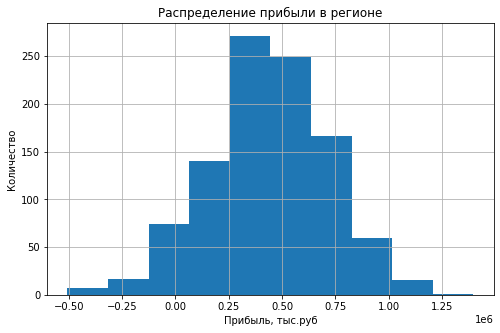

Средняя прибыль: 435.93 млн.руб
Прибыль вероятностью с 95% от: -116.23 млн.руб до: 966.50 млн.руб
95%-ый доверительный интервал: от 418.76 млн.руб до 453.11 млн.руб
Веросятность убытка в данном регионе: 6.1%


In [43]:
bootstap_1000(target_valid_1,predict_1)

**Распределение прибыли 2 региона**

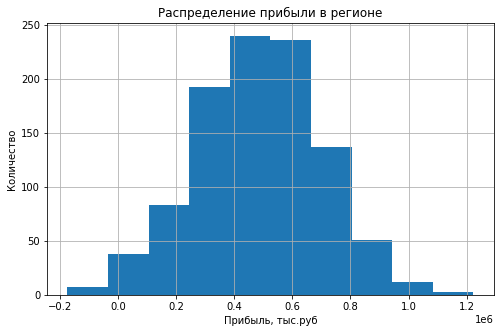

Средняя прибыль: 489.66 млн.руб
Прибыль вероятностью с 95% от: 55.12 млн.руб до: 905.76 млн.руб
95%-ый доверительный интервал: от 476.23 млн.руб до 503.09 млн.руб
Веросятность убытка в данном регионе: 1.1%


In [44]:
bootstap_1000(target_valid_2,predict_2)

**Распределение прибыли 3 региона**

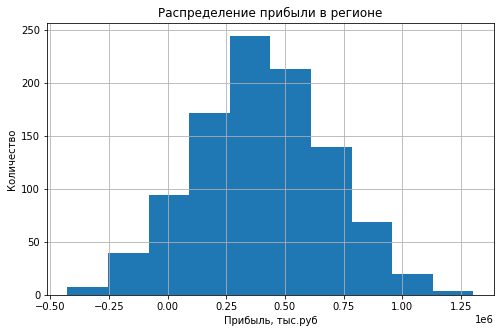

Средняя прибыль: 403.69 млн.руб
Прибыль вероятностью с 95% от: -153.12 млн.руб до: 952.89 млн.руб
95%-ый доверительный интервал: от 386.21 млн.руб до 421.17 млн.руб
Веросятность убытка в данном регионе: 7.1%


In [45]:
bootstap_1000(target_valid_3,predict_3)

### Выбор региона для разработки месторождения

**После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью**

In [47]:
comparison_tabl = pd.DataFrame(index=['Средняя прибыль в регионе, млн.руб','Суммарный запас сырья, тыс.баррелей','Вероятность убытка, %'], columns=['1 регион','2 регион','3 регион'])
comparison_tabl['1 регион'] = '435.93', '30881.96','6.1'
comparison_tabl['2 регион'] = '489.66', '27748.75','1.1'
comparison_tabl['3 регион'] = '403.69', '29730.68','7.1'
comparison_tabl

,1 регион,2 регион,3 регион
"Средняя прибыль в регионе, млн.руб",435.93,489.66,403.69
"Суммарный запас сырья, тыс.баррелей",30881.96,27748.75,29730.68
"Вероятность убытка, %",6.1,1.1,7.1


### Итог выбора региона

- Под критерий "вероятность убытков меньше 2.5%" попадает только второй регион
- Его средняя прибыль составит 489.66 млн.руб

## Вывод

- Мы исследовали данные и обучили модели по каждому региону
- Стало известно что при разработке региона вложения в них не окупятся
- Мы обучили модели, выбрав по 200 лучших скважин в каждом регионе и спрогнозировали среднюю прибыль и вероятность убытков в каждом регионе
- Таким образом мы выбрали 2 регион для разработки 200 скважин, что принесет в среднем прибыль в 489.66 млн.руб, а вероятность убытков всего 1.1% 

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован